In [16]:
%pip install bayesian-optimization

In [0]:
import matplotlib.pyplot as plt
import numpy as np
import os, contextlib, sys
#rom loaddata import loaddata
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
from sklearn.metrics import explained_variance_score, r2_score
from sklearn.preprocessing import quantile_transform
from bayes_opt import BayesianOptimization
from sklearn.model_selection import KFold


In [18]:
%cd /content/drive/My\ Drive/Colab\ Notebooks

/content/drive/My Drive/Colab Notebooks


In [0]:
np.random.seed(seed=1)

In [0]:
gpu = torch.device("cuda:0")

In [0]:
def loaddata(directory):
    feature_list = list()
    train_data_list = list()
    train_target_list = list()
    for i,filename in enumerate(os.listdir(directory)):
        raw_data = np.genfromtxt(f'{directory}/{filename}', delimiter=',', names=True)
        data_matrix = np.genfromtxt(f'{directory}/{filename}', delimiter=',',skip_header=1)
        
        if i==0: 
            feature_list.append(raw_data.dtype.names)
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
        elif i==len(os.listdir(directory))-1:
            test_data = data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]]
            test_target = data_matrix[:,1]
        else:
            train_data_list.append(data_matrix[:,[i for i in range(len(data_matrix[1])) if i!=1]])
            train_target_list.append(data_matrix[:,1])
    #train_data_list = np.vstack((train_data_list))
    #train_target_list =  np.concatenate(train_target_list)
    return train_data_list, train_target_list, test_data, test_target

def get_explained(model, data, target):
    model.eval()
    pred = model(data).squeeze().detach().numpy()
    target = target.detach().numpy()

    return explained_variance_score(target, pred), r2_score(target, pred)
    


In [0]:
train_data_list, train_target_list, test_data, test_target = loaddata('data')

In [0]:
train_data_list = [quantile_transform(data,n_quantiles=100,copy=True) for data in train_data_list]
test_data = quantile_transform(test_data,n_quantiles=100,copy=True)

In [0]:
train_data_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_data_list]
train_target_torch = [torch.from_numpy(data).unsqueeze(dim=1).float().to(gpu) for data in train_target_list]
test_data_torch, test_target_torch = torch.from_numpy(np.array(test_data)).unsqueeze(dim=1).float().to(gpu), torch.from_numpy(np.array(test_target)).float().to(gpu)


In [0]:
class LSTMTagger(nn.Module):

    def __init__(self, inputsize, layers, hiddensize, drop_out):
        super(LSTMTagger, self).__init__()
        self.inputsize = inputsize
        self.hiddensize = hiddensize
        self.layers = layers
        self.drop_out = drop_out

        self.lstm = nn.LSTM(input_size=self.inputsize, hidden_size = self.hiddensize, num_layers=layers, dropout=drop_out)
        self.hidden2radial = nn.Linear(in_features=hiddensize, out_features=1)

    def forward(self, x):
        x, _ = self.lstm(x)
        x = F.relu(x)
        x = self.hidden2radial(x)
        return x

In [0]:
n_epochs = 500

In [0]:
def NN_CrossValidation(hiddensize, layers, learning_rate, drop_out, data, targets):
    estimator = LSTMTagger(27,layers=layers, hiddensize=hiddensize, drop_out=drop_out).to(gpu)
    optimizer = torch.optim.Adam(estimator.parameters(), lr=learning_rate)
    acc_list = list()
    loss_list = list()
    for i,valdata in enumerate(data):
      traindata = data[:i] + data[i+1:]
      traintarget = targets[:i] + targets[i+1:]
      valtarget = targets[i]
      n_epochs = 500
      criterion = nn.MSELoss()
      estimator.train()
      for e in range(n_epochs):
          epoch_evs = list()
          epoch_losses = list()
          for batch in range(len(traindata)):
            estimator.zero_grad()
            optimizer.zero_grad() 
            prediction = estimator(traindata[batch])
            target = traintarget[batch]
            # Calculating the loss function
            loss = criterion(prediction.squeeze(dim=2),target)
            epoch_losses.append(float(loss))
            #evs = explained_variance_score(target.squeeze(dim=1).detach().cpu().numpy(),prediction.squeeze(dim=1).detach().cpu().numpy())
            #epoch_evs.append(evs)
            # Calculating the gradient  
            loss.backward()
            optimizer.step()
          #print(e, np.mean(epoch_losses), np.mean(epoch_evs))
      #loss_list.append(np.mean(epoch_losses))
      with torch.no_grad():
          estimator.eval()
          train_prediction = estimator(valdata).squeeze(dim=1)
          #loss_list.append( float(criterion((train_prediction),valtarget).detach().cpu()) )
          acc_list.append( explained_variance_score(valtarget.cpu(), train_prediction.cpu()) )
    return np.mean(acc_list)

  

def optimize_NN(data, targets, pars, n_iter=10):
    def crossval_wrapper(hiddensize, layers, learning_rate, drop_out):
        return NN_CrossValidation(hiddensize=int(hiddensize), layers=int(layers), learning_rate=learning_rate, drop_out=drop_out,
                                            data=data, 
                                            targets=targets)

    optimizer = BayesianOptimization(f=crossval_wrapper, 
                                     pbounds=pars, 
                                     random_state=27, 
                                     verbose=2)
    optimizer.maximize(init_points=5, n_iter=n_iter)

    return optimizer


In [0]:
parameters_BO = {"hiddensize": (400,500), "learning_rate": (0.0005,0.0001),"layers": (2,3),"drop_out": (0.1,0.3)}

optimization_data = train_data_torch
optimization_target = train_target_torch


BO = optimize_NN(optimization_data,optimization_target,parameters_BO,n_iter=5)

print(BO.max)

params = BO.max['params']



for key, val in params.items():
    if key == 'hiddensize':
        params[key] = int(val)
    if key =='learning_rate':
        params[key] = val
    if key == 'layers':
        params[key] = int(val)
    if key == 'drop_out':
        params[key] = val

|   iter    |  target   | drop_out  | hidden... |  layers   | learni... |
-------------------------------------------------------------------------


In [45]:
model = LSTMTagger(27,layers=params['layers'], hiddensize=params['hiddensize'],drop_out=params['drop_out']).to(gpu)

criterion = nn.MSELoss()

optimizer = optim.Adam(model.parameters(),lr=params['learning_rate'])

for i,valdata in enumerate(train_data_torch):
      traindata = train_data_torch[:i] + train_data_torch[i+1:]
      traintarget = train_target_torch[:i] + train_target_torch[i+1:]
      valtarget = train_target_torch[i]
      n_epochs = 100
      model.train()
      for e in range(n_epochs):
          epoch_losses = list()
          epoch_evs = list()
          for batch in range(len(train_data_list)):
              model.zero_grad()
              optimizer.zero_grad() 
              prediction = model(train_data_torch[batch])
              target = train_target_torch[batch]
              # Calculating the loss function
              loss = criterion(prediction.squeeze(dim=2), target)
              epoch_losses.append(float(loss))
              evs = explained_variance_score(target.squeeze(dim=1).detach().cpu().numpy(),prediction.squeeze(dim=1).detach().cpu().numpy())
              epoch_evs.append(evs)
              # Calculating the gradient
              loss.backward()
              optimizer.step()
          print(e, np.mean(epoch_losses),np.mean(epoch_evs))


0 14946.001953125 -2.5272369384765625e-05
1 14944.240885416666 2.205371856689453e-05
2 14943.120361328125 6.661812464396159e-05
3 14942.050130208334 0.00012252728144327799
4 14940.901936848959 0.00017380714416503906
5 14939.565836588541 0.00023980935414632162
6 14937.856119791666 0.0003323554992675781
7 14935.738118489584 0.00045154492060343426
8 14932.770263671875 0.0006246566772460938
9 14928.677001953125 0.0008921225865681967
10 14921.733072916666 0.0013882915178934734
11 14909.126383463541 0.002381304899851481
12 14874.511149088541 0.005809287230173747
13 14761.803059895834 0.009718577067057291
14 14656.06884765625 0.011144042015075684
15 14565.116943359375 0.032308220863342285
16 14513.157145182291 0.0467643141746521
17 14488.232584635416 0.05155088504155477
18 14444.85205078125 0.05176341533660889
19 14403.533935546875 0.04854591687520345
20 14367.799641927084 0.043873727321624756
21 14329.11865234375 0.04879822333653768
22 14285.498128255209 0.062047203381856285
23 14249.4452311

In [0]:
time = test_data[:,0]
data_plot = test_data_torch
RV_pred = model(data_plot).squeeze(dim=2).detach().cpu().numpy()
RV_true = test_target

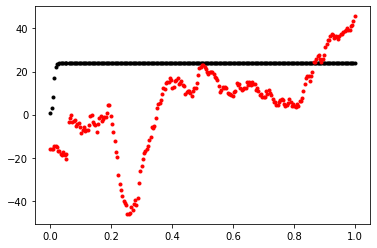

In [47]:
plt.figure(1)
plt.plot(time,RV_pred,'k.')
plt.plot(time,RV_true, 'r.')
plt.show()